# Assignment

Build a Choropleth map which shows intuitively (i.e., use colors wisely) how much grant money goes to each Swiss canton. To do so, you will need to use the provided TopoJSON file, combined with the Choropleth map example you can find in the Folium README file.
HINT: the P3 database is formed by entries which assign a grant (and its approved amount) to a University name. Therefore you will need a smart strategy to go from University to Canton name. The Geonames Full Text Search API in JSON can help you with this -- try to use it as much as possible to build the canton mappings that you need. For those universities for which you cannot find a mapping via the API, you are then allowed to build it manually -- feel free to stop by the time you mapped the top-95% of the universities. I also recommend you to use an intermediate viz step for debugging purposes, showing all the universties as markers in your map (e.g., if you don't select the right results from the Geonames API, some of your markers might be placed on nearby countries...)

BONUS: using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in research funding between the areas divided by the Röstigraben?

# Getting started

## Imports

In [552]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import folium
import json
import csv

from googleplaces import GooglePlaces, types, lang

## Read data from grant report

In [553]:
# read csv file. we notice that a lot of NaN value is present, so we replace them with empty field for better visual
grantReport = pd.read_csv('data/P3_GrantExport.csv', delimiter=';')
grantReport = grantReport.fillna('')
grantReport.head()

,"﻿""Project Number""",Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
0,1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,,Kaegi Werner,Project funding (Div. I-III),Project funding,,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,11619.00,
1,4,Batterie de tests à l'usage des enseignants po...,,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",01.10.1975,30.09.1976,41022.00,
2,5,"Kritische Erstausgabe der ""Evidentiae contra D...",,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,01.03.1976,28.02.1985,79732.00,
3,6,Katalog der datierten Handschriften in der Sch...,,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,52627.00,
4,7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,01.01.1976,30.04.1978,120042.00,


## Clean up

From the chart above, we are interested in nothing but two columns: _University_ and _Approved Amount_.

In [554]:
grantReport = grantReport[['Approved Amount', 'University']]
grantReport.head()

,Approved Amount,University
0,11619.00,Nicht zuteilbar - NA
1,41022.00,Université de Genève - GE
2,79732.00,"NPO (Biblioth., Museen, Verwalt.) - NPO"
3,52627.00,Universität Basel - BS
4,120042.00,"NPO (Biblioth., Museen, Verwalt.) - NPO"


First we check the universities.

In [555]:
grantReport.University.unique().shape

(78,)

Seems there are not so many different universities. So we list all of them to check outliers.

In [556]:
uni = grantReport.University.unique()
uni

array(['Nicht zuteilbar - NA', 'Université de Genève - GE',
       'NPO (Biblioth., Museen, Verwalt.) - NPO', 'Universität Basel - BS',
       'Université de Fribourg - FR', 'Universität Zürich - ZH',
       'Université de Lausanne - LA', 'Universität Bern - BE',
       'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL',
       'Université de Neuchâtel - NE', 'ETH Zürich - ETHZ',
       'Inst. de Hautes Etudes Internat. et du Dév - IHEID',
       'Universität St. Gallen - SG', 'Weitere Institute - FINST',
       'Firmen/Privatwirtschaft - FP',
       'Pädagogische Hochschule Graubünden - PHGR', 'EPF Lausanne - EPFL',
       'Pädagogische Hochschule Zürich - PHZFH', 'Universität Luzern - LU',
       'Schweiz. Institut für Kunstwissenschaft - SIK-ISEA',
       'SUP della Svizzera italiana - SUPSI',
       'HES de Suisse occidentale - HES-SO',
       'Robert Walser-Stiftung Bern - RWS', 'Paul Scherrer Institut - PSI',
       'Pädagogische Hochschule St. Gallen - PHSG',
       'Eidg. Ans

After a quick check, we find some of the entries don't refer to a specific university, but some institutions in a specific area. They are:
- Nicht zuteilbar - NA
- Weitere Institute - FINST (_other institute_)
- Weitere Spitäler - ASPIT (_other hospital_)
- NPO (Biblioth., Museen, Verwalt.) - NPO (_non profit orgs_)
- Firmen/Privatwirtschaft - FP (_companies_)

In [557]:
invalidUniversities = ['Nicht zuteilbar - NA', 
                       'Weitere Institute - FINST', 
                       'Weitere Spitäler - ASPIT', 
                       'NPO (Biblioth., Museen, Verwalt.) - NPO',
                       'Firmen/Privatwirtschaft - FP']
grantReport.University = grantReport.University.replace(invalidUniversities, '')
grantReport = grantReport[grantReport.University != '']

In [558]:
uni = grantReport.University.unique()
uni.shape

(72,)

Great, we have kicked out outliers in University column. Now we do the same for the _Approved Amount_.

In [559]:
# we take an iterative way. valid amounts should be able to be transfered into floats with 'astype' method. do this:
# sum(pd.to_numeric(grantReport['Approved Amount'], errors='coerce'))
# when we try the above code, python returns an error:  could not convert string to float: 'data not included in P3'. we kick this out.
invalidAmounts = ['data not included in P3']
grantReport['Approved Amount'] = grantReport['Approved Amount'].replace(invalidAmounts, '')
grantReport = grantReport[grantReport['Approved Amount'] != '']
sum(pd.to_numeric(grantReport['Approved Amount'], errors='coerce'))
# do the code again. this time it works! seems we have only one type of invalid entry in 'Approved Amount'.


12369619629.330006

In [560]:
grantReport.shape

(46194, 2)

## Assign universities to cantons

### Import Google Map Services

Here we use Google Map Services to retrieve geo information by querying university names.

In [426]:
# use your key
API_KEY = 'HIDED_KEY'

if API_KEY != 'HIDED_KEY':
    google_places = GooglePlaces(API_KEY)        

First we try to play around with an instance in the `uni` array.

In [427]:
response = google_places.text_search(query = uni[5])
if response.places:
    place = response.places[0]
place

<Place name="University of Bern", lat=46.9504896, lng=7.438119000000002>

In [428]:
place.get_details()
details = place.details
for component in details['address_components']:
    if 'administrative_area_level_1' in component['types']:
        canton = component['short_name']
canton

'BE'

Seems good. Now we sum it up as functions for future use.

In [429]:
def text_search(name):
    response = google_places.text_search(query = name)
    return response

def uni_to_canton(name):
    response = text_search(name)
    canton = 'not found'
    if response.places:
        place = response.places[0]
        place.get_details()
        details = place.details
        for component in details['address_components']:
            if 'administrative_area_level_1' in component['types']:
                canton = component['short_name']
    return canton

def add_mapping_to_dict(existingDict, name):
    existingDict[name] = uni_to_canton(name)
    return existingDict

In [430]:
# mapping process. WARNING: DAILY QUOTA RESTRICTED
uniDict = {}
for u in uni:
    add_mapping_to_dict(uniDict, u)

To avoid query overflow, we save the dictionary locally.

In [431]:
uniDict_path = 'data/uniDict.json'
with open(uniDict_path, 'w') as js:
    json.dump(uniDict, js)

In [561]:
# read json file
with open(uniDict_path, 'r') as js:
    uniDict = json.load(js)

### Fill 'not found' items

In [562]:
for key, value in uniDict.items():
    if value == 'not found':
        print(key)

Zürcher Fachhochschule (ohne PH) - ZFH
Staatsunabh. Theologische Hochschule Basel - STHB
Forschungsanstalten Agroscope - AGS
AO Research Institute - AORI
Forschungsinstitut für Opthalmologie - IRO
Forschungskommission SAGW
Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL
Schweizer Kompetenzzentrum Sozialwissensch. - FORS
Pädagogische Hochschule Wallis - PHVS
Physikal.-Meteorolog. Observatorium Davos - PMOD
Swiss Center for Electronics and Microtech. - CSEM
Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP


In [563]:
# Now we fix them manually.
uniDict['Zürcher Fachhochschule (ohne PH) - ZFH'] = 'ZH'
uniDict['Forschungsinstitut für Opthalmologie - IRO'] = 'VS'
uniDict['Forschungsanstalten Agroscope - AGS'] = 'BE'
uniDict['AO Research Institute - AORI'] = 'GR'
uniDict['Forschungskommission SAGW'] = 'BE'
uniDict['Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL'] = 'ZH'
uniDict['Schweizer Kompetenzzentrum Sozialwissensch. - FORS'] = 'VD'
uniDict['Pädagogische Hochschule Wallis - PHVS'] = 'VS'
uniDict['Swiss Center for Electronics and Microtech. - CSEM'] = 'NE'
uniDict['Physikal.-Meteorolog. Observatorium Davos - PMOD'] = 'GR'
uniDict['Staatsunabh. Theologische Hochschule Basel - STHB'] = 'BS'
uniDict['Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP'] = 'TI'

In [564]:
uniDict.values()

dict_values(['ZH', 'TI', 'GR', 'SG', 'GE', 'SG', 'LU', 'ZH', 'SH', 'FR', 'ZH', 'ZG', 'LU', 'BE', 'ZH', 'BE', 'VS', 'ZH', 'BS', 'VS', 'Lazio', 'BS', 'BE', 'BS', 'ZH', 'GR', 'VS', 'SZ', 'ZH', 'BE', 'JU', 'TI', 'FR', 'HE', 'BE', 'GE', 'SG', 'GR', 'AG', 'ZH', 'ZH', 'VD', 'VS', 'VD', 'SO', 'SG', 'VS', 'TI', 'TG', 'GR', 'VS', 'TG', 'ZH', 'TI', 'GE', 'TI', 'GR', 'SG', 'BL', 'VD', 'NE', 'NE', 'LU', 'TI', 'VD', 'VD', 'BE', 'BE', 'JU', 'NE', 'LU', 'TI'])

We also see an entry called 'Lazio' in the dict. It's obviously not in Switzerland but in Italy. We can remove it later.

### Add Canton column in dataframe

Now, to prepare for the choropleth, we create a new column called `Canton` to map universities with cantons.


In [565]:
grantReport['Canton'] = np.nan
for u in uni:
    grantReport.loc[grantReport.University == u, 'Canton'] = uniDict[u]
grantReport.shape

(46194, 3)

In [566]:
# delete rows in "Canton" Lazio
grantReport = grantReport[grantReport.Canton != 'Lazio']
grantReport.shape

(46188, 3)

In [567]:
grantReport.head()

,Approved Amount,University,Canton
1,41022.00,Université de Genève - GE,GE
3,52627.00,Universität Basel - BS,BS
5,53009.00,Université de Fribourg - FR,FR
6,25403.00,Université de Fribourg - FR,FR
7,47100.00,Universität Zürich - ZH,ZH


This `grantReport` is exactly the data frame we want.

# Plot

Since we have already everything we desire, it's time create the choropleth. We will use a logarithmic scale because the total money spent per canton is high and the differences are too remarkable.

In [568]:
grantReport['Approved Amount'] = pd.to_numeric(grantReport['Approved Amount'], errors='coerce')

In [500]:
topo_path = r'ch-cantons.topojson.json'

with open(topo_path) as data_file:    
    crl = json.load(data_file)
    
# retrieve the name of the cantons from the topojson
cantonNames = []
for i in range(0,26):
    cantonNames.append(crl['objects']['cantons']['geometries'][i]['id'])
    
# calculate grant sum for each canton
grantSum = np.r_[0:26] * 0.0
for i in range(0,len(grantReport.Canton.unique())):
    canton = grantReport.Canton.unique()[i]
    if canton in cantonNames:
        grantSum[cantonNames.index(canton)] = grantReport[grantReport.Canton == canton]['Approved Amount'].sum()
    
countDF = pd.DataFrame({'Canton': cantonNames, 'Grant': np.log10(grantSum+1)})

sc = np.linspace(0, np.max(countDF.Grant), 6)

map_4 = folium.Map(location=[46.57, 7.27], tiles = 'Mapbox bright', zoom_start=8)
map_4.choropleth(geo_path=topo_path, topojson = 'objects.cantons', data = countDF,
                 columns=['Canton', 'Grant'],
                 threshold_scale=list(sc),
                 key_on='feature.id',
                 fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                 legend_name='Total grants per Canton in a log scale')
map_4.save('grantMap.html')

***The final choropleth map is hosted at https://ada-choropleth.herokuapp.com/. (takes 20 sec to open if server is in sleep mode)***

# Bonus

To divide the total grant by Röstigraben, we create a dataFrame for each of three areas: Swiss-French, Swiss-German, and Swiss-Italian. Since Swiss-German is dominant in size, we try to find out universities in Swiss-French and Swiss-Italian.

The best way is to do the division by university names. French named universities are classified as Swiss-French, Italian named universities are Swiss-Italian, etc.

All the external data and linguistic/cartographic knowledges in this section come from:

https://en.wikipedia.org/wiki/Languages_of_Switzerland

In [569]:
# get ready
grantReport['Language'] = ''

## Swiss-French

In [570]:
# cantons that goes full French
grantReport.loc[grantReport.Canton.isin(['GE', 'VD', 'NE', 'JU']), 'Language'] = 'French'

In [571]:
# cantons that are mixed with French and German
# record french names
grantReport[grantReport.Canton.isin(['FR', 'VS', 'BE'])].University.unique()

array(['Université de Fribourg - FR', 'Universität Bern - BE',
       'Robert Walser-Stiftung Bern - RWS', 'Berner Fachhochschule - BFH',
       'Forschungsanstalten Agroscope - AGS',
       'Eidg. Hochschulinstitut für Berufsbildung - EHB',
       "Centre de rech. sur l'environnement alpin - CREALP",
       'Idiap Research Institute - IDIAP',
       'Pädagogische Hochschule Bern - PHBern',
       'Institut Universitaire Kurt Bösch - IUKB',
       'Forschungsinstitut für Opthalmologie - IRO',
       'Forschungskommission SAGW',
       'Haute école pédagogique fribourgeoise - HEPFR',
       'Pädagogische Hochschule Wallis - PHVS',
       'Fernfachhochschule Schweiz (Mitglied SUPSI) - FFHS'], dtype=object)

In [572]:
# list of all French universities in FR, VS and BE, which are German/French-mixed cantons
frenchUniversities = ['Université de Fribourg - FR',
                      "Centre de rech. sur l'environnement alpin - CREALP",
                      'Idiap Research Institute - IDIAP',
                      'Institut Universitaire Kurt Bösch - IUKB',
                      'Haute école pédagogique fribourgeoise - HEPFR']

In [573]:
# keep the universities with French names
grantReport.loc[grantReport.University.isin(frenchUniversities), 'Language'] = 'French'
grantReport.head()

,Approved Amount,University,Canton,Language
1,41022.0,Université de Genève - GE,GE,French
3,52627.0,Universität Basel - BS,BS,
5,53009.0,Université de Fribourg - FR,FR,French
6,25403.0,Université de Fribourg - FR,FR,French
7,47100.0,Universität Zürich - ZH,ZH,


## Swiss-Italian

In [574]:
# just Ticino
grantReport.loc[grantReport.Canton.isin(['TI']), 'Language'] = 'Italian'
grantReport[grantReport.Canton == 'TI'].head()

,Approved Amount,University,Canton,Language
704,60000.0,SUP della Svizzera italiana - SUPSI,TI,Italian
3644,133500.0,SUP della Svizzera italiana - SUPSI,TI,Italian
4140,44000.0,SUP della Svizzera italiana - SUPSI,TI,Italian
4592,203383.0,SUP della Svizzera italiana - SUPSI,TI,Italian
5847,96200.0,Ente Ospedaliero Cantonale - EOC,TI,Italian


## Swiss-German

In [576]:
# just replace the other NaN value to German
grantReport.Language = grantReport.Language.replace('', 'German')
grantReport.head()

,Approved Amount,University,Canton,Language
1,41022.0,Université de Genève - GE,GE,French
3,52627.0,Universität Basel - BS,BS,German
5,53009.0,Université de Fribourg - FR,FR,French
6,25403.0,Université de Fribourg - FR,FR,French
7,47100.0,Universität Zürich - ZH,ZH,German


In [577]:
# check
sum(grantReport.Language == '')

0

## Sum it up

In [579]:
langs = ['French', 'German', 'Italian']
amounts = [0.0] * 3

for lang in langs:
    amounts[langs.index(lang)] = grantReport[grantReport.Language == lang]['Approved Amount'].sum()

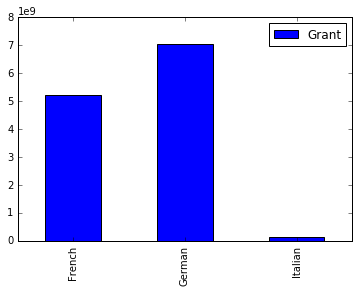

In [582]:
rostiDF = pd.DataFrame({'Grant': amounts}, index = langs)
rostiDF.plot(kind='bar')

This bar chart doesn’t imply anything, because the population and area of three territories are so much different. Another chart sounds more interesting to us: __grant per capita__. The population data is [from here](https://en.wikipedia.org/wiki/Languages_of_Switzerland#Other_languages).

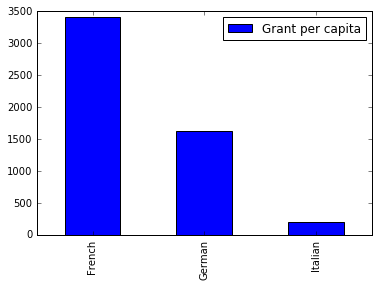

In [586]:
mainLanguagePopulation = [1525003, 4348289, 561857] # population in 2013 in terms of main language
perCapita = [amount/pop for amount, pop in zip(amounts, mainLanguagePopulation)]
rostiPerCapitaDF = pd.DataFrame({'Grant per capita': perCapita}, index = langs)
rostiPerCapitaDF.plot(kind='bar')

It seems that Swiss-French people have the larges scholar grant per capita, while Swiss-Italians have the least.